# 20 Newsgroups Text Clustering

The goal in this notebook is to perform a comparative analysis
of various clustering and dimension reduction techniques on the
20 Newgroups dataset.

I will be using the training subset consisting of 10723 documents
with 19 categories where the 'comp.os.ms-windows.misc' category
is exluded as it contains nothing but data.

---
**The Work flow is as follows:**

1. Load to dataset
2. Pre-Process the text data
    - remove headers,footers,quotes
    - convert to lowercase
    - remove puncuation
    - apply stoplist
3. Vectorize text into a TF-IDF matrix
4. Apply Reduction techniques or none
5. Perform and Analyze Clustering outcomes.

<img src='https://drive.google.com/uc?id=15nl75CAnS0R6iC9JDhptgqeTCHKN-TGE' width='500' height='500'/>

## Explanation of Terms
---
### TF-IDF Matrix
A matrix representation for a Corpus of text docuements
where each document is represented by a vector, and
each feature is determined by the TF-IDF values.
- **Term Frequency (TF):** Measures how frequently a term appears in a document.
- **Inverse Document Frequency (IDF):** Measures how important a term is within the entire corpus. Rare terms across documents have a higher IDF.

### LSA (Latent Semantic Analysis)
Latent Semantic Analysis (LSA) is a dimensionality reduction technique used to extract the underlying relationships between words in a text corpus. It is often applied to the TF-IDF matrix to reduce the number of features (words) and find latent structures in the data.

### PCA (Principal Component Analysis)
Principal Component Analysis (PCA) is a technique for reducing the dimensionality of data by projecting it onto a new set of orthogonal axes (called principal components) that maximize the variance of the data.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from time import time
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from tabulate import tabulate
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import SpectralCoclustering
from sklearn.metrics.cluster import v_measure_score
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.patches as mpatches

In [ ]:
# exclude 'comp.os.ms-windows.misc'
categories = [
    "alt.atheism",
    "comp.graphics",
    "comp.sys.ibm.pc.hardware",
    "comp.sys.mac.hardware",
    "comp.windows.x",
    "misc.forsale",
    "rec.autos",
    "rec.motorcycles",
    "rec.sport.baseball",
    "rec.sport.hockey",
    "sci.crypt",
    "sci.electronics",
    "sci.med",
    "sci.space",
    "soc.religion.christian",
    "talk.politics.guns",
    "talk.politics.mideast",
    "talk.politics.misc",
    "talk.religion.misc",
]
# fetching dataset, removing headers,footers
newsgroups = fetch_20newsgroups(categories=categories,remove=('headers','footers'))
labels = newsgroups.target # captures correct labels
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0] # True number of clusters
print(f'Numbers of Documents in dataset: {len(newsgroups.data)}')
print(f'Number of Document Classifications: {true_k}')
print(f'distribution of clusters: {category_sizes}\n')

Numbers of Documents in dataset: 10723
Number of Document Classifications: 19
distribution of clusters: [480 584 590 578 593 585 594 598 597 600 595 591 594 593 599 546 564 465
 377]



As we can see the dataset as been extracted with 19 categories and ~11,000 documents.

# SAMPLE ENTRY
Below is a text entry from the 'misc.forsale' category.

```
*******************************************************
                   1969 karmann ghia
*******************************************************

This car is in excellent running condition:
               *********
  *49,000 mi on new engine
  *new tires (Aug 92)
  *new clutch (91)
  *new carb (91)
  *original radio (am/fm)
  *upholstery in great shape
  *burgundy exterior/ black interior

This car has been well-maintained with regular tune-ups.
Unfortunately, the car's previous owner had a minor
front-end collision.  The right front nose is dented
and patched up with bondo.  I have the hard-to-find part
needed to repair this damage.  Besides that damage, the car
is in excellent condition. $1600/bo
```

In [ ]:
# Creating A vectorizer
# then outputting the sample tokenized values from the sample text above.
vectorizer = TfidfVectorizer(
    lowercase=True,
    max_df=0.5,
    min_df=5,
    stop_words="english",
    max_features = 10000
)
analyzer = vectorizer.build_analyzer()
print('First 10 Tokens generated from the text:')
print(analyzer(newsgroups.data[0])[:10])

X = vectorizer.fit_transform(newsgroups.data)

First 10 Tokens generated from the text:
['1969', 'karmann', 'ghia', 'car', 'excellent', 'running', 'condition', '49', '000', 'mi']


# TF-IDF Matrix

From these tokens we form our TF-IDF matrix, which will be capped at 10,000 terms and sparesly packed meaning many 0 values. Each row is a document and feature a token in our vocabulary.

\begin{bmatrix}
1969_{1,1} & karmann_{1,2} & \dots & mi_{1,m} \\
TF-IDF_{2,1} & TF-IDF_{2,2} & \dots & TF-IDF_{2,m} \\
\vdots & \vdots & \ddots & \vdots \\
TF-IDF_{n,1} & TF-IDF_{n,2} & \dots & TF-IDF_{n,m}
\end{bmatrix}


Next we will begin our clustering using Kmeans, Agglomerative , Spectral on the reduced dataset comparing computation time and accuracy scores.

In [ ]:
# Define clustering methods
NUM_DIM = 100
methods = [
    ('K-means plain', KMeans(n_clusters=true_k, random_state=42, init='k-means++', n_init=5)),

     ('K-means LSA', make_pipeline(TruncatedSVD(n_components=NUM_DIM, random_state=42),
                                   Normalizer(copy=False),
                                   KMeans(n_clusters=true_k,random_state=42,init='k-means++',n_init=5))),

     ('K-means PCA', make_pipeline(PCA(n_components=NUM_DIM,random_state=42),
                                   Normalizer(copy=False),
                                   KMeans(n_clusters=true_k,random_state=42, init='k-means++',n_init=5))),

     ('Agglo LSA', make_pipeline(TruncatedSVD(n_components=NUM_DIM, random_state=42),
                                Normalizer(copy=False),
                                AgglomerativeClustering(n_clusters=true_k))),

     ('Agglo PCA', make_pipeline(PCA(n_components=NUM_DIM, random_state=42),
                                Normalizer(copy=False),
                                AgglomerativeClustering(n_clusters=true_k))),

     ('Spectral LSA', make_pipeline(TruncatedSVD(n_components=NUM_DIM, random_state=42), Normalizer(copy=False), SpectralClustering(n_clusters=true_k)))
]
table_results = []

# List to store clustering results and method names
labels_list = []
method_names = []
cluster_sizes = []

pca = PCA(n_components=2)
reduced_matrix = pca.fit_transform(X)

# Loop through each method, perform clustering, compute metrics, and plot
for idx, (method_name, method) in enumerate(methods):
    t0 = time()
    if isinstance(method, Pipeline):
        # Fit the pipeline and make predictions
        labels_pred = method.fit_predict(X)
    else:
        # For KMeans, Agglo and Spectral without pipeline
        labels_pred = method.fit_predict(X)

    print(f"{method_name} done in {time() - t0:.3f} s")

    # Store labels for later analysis
    labels_list.append(labels_pred)
    method_names.append(method_name)

    # store cluster sizes
    cluster_ids, cluster_size = np.unique(labels_pred, return_counts=True)
    cluster_sizes.append(cluster_size)

    # Compute clustering metrics
    homogenity = metrics.homogeneity_score(labels, labels_pred)
    completeness = metrics.completeness_score(labels, labels_pred)
    v_measure = metrics.v_measure_score(labels, labels_pred)
    inertia = metrics.silhouette_score(X, labels_pred, sample_size=2500)

    # Append the results to the table
    table_results.append([method_name, homogenity, completeness, v_measure, inertia])

cluster_sizes.insert(3,category_sizes)

K-means plain done in 14.791 s
K-means LSA done in 3.874 s
K-means PCA done in 8.370 s
Agglo LSA done in 14.707 s
Agglo PCA done in 19.221 s
Spectral LSA done in 54.346 s


# Computation Time

as seen from the output, K-means with LSA reduced array performed the fastest in nearly half of the time as the next closest K-means with PCA.

In [ ]:
# Show results table
table_headers = [
    'Method',
    'Homogeneity',
    'Completeness',
    'V-measure',
    'Sil Coeficient'
]
print(tabulate(table_results, headers=table_headers, tablefmt='grid'))

+---------------+---------------+----------------+-------------+------------------+
| Method        |   Homogeneity |   Completeness |   V-measure |   Sil Coeficient |
+===============+===============+================+=============+==================+
| K-means plain |      0.364133 |       0.41664  |    0.388621 |       0.0078865  |
+---------------+---------------+----------------+-------------+------------------+
| K-means LSA   |      0.471176 |       0.490455 |    0.480622 |       0.00620456 |
+---------------+---------------+----------------+-------------+------------------+
| K-means PCA   |      0.48073  |       0.496761 |    0.488614 |       0.00819813 |
+---------------+---------------+----------------+-------------+------------------+
| Agglo LSA     |      0.38632  |       0.432119 |    0.407938 |       0.0065796  |
+---------------+---------------+----------------+-------------+------------------+
| Agglo PCA     |      0.385399 |       0.443408 |    0.412373 |      -0.037

# Accuracy Score Takeaways
1. Dimensionality reduction clearly helps, reduced datasets performed best.
2. LSA reduction seems to slightly outperform PCA.
3. K-means beats Agglomerative and Spectral.
4. The clusters still have very high degrees of overlap.



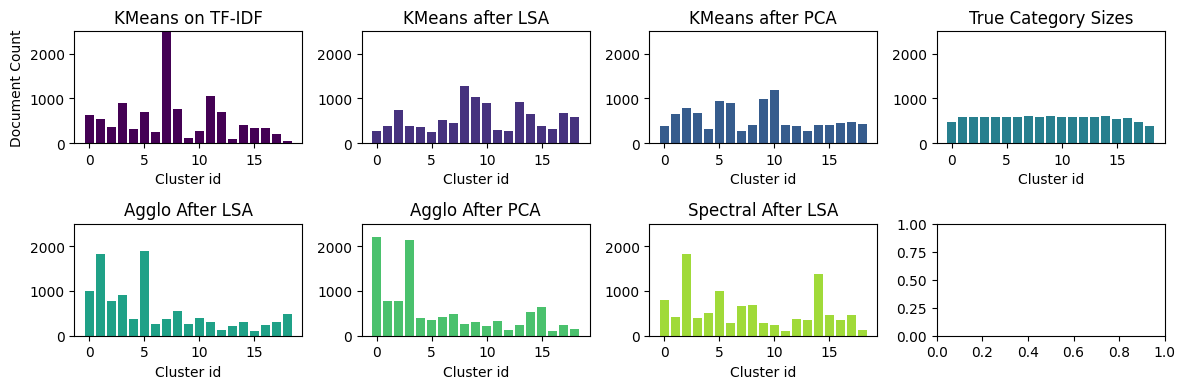

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(12, 4))
axes = axes.flatten()
titles = [
    "KMeans on TF-IDF",
    "KMeans after LSA",
    "KMeans after PCA",
    "True Category Sizes",
    'Agglo After LSA',
    'Agglo After PCA',
    'Spectral After LSA'
]
colors = colors = [plt.cm.viridis(i / len(titles)) for i in range(len(titles))]
x = np.arange(true_k)
for ax, data, title, color in zip(axes, cluster_sizes, titles, colors):
    ax.bar(x, data, color=color)
    ax.set_title(title)
    ax.set_xlabel("Cluster id")
    ax.set_ylim(0,2500)

axes[0].set_ylabel("Document Count")

plt.tight_layout()
plt.show()

# Plot Explanation

The Plot above shows the size of each category, Kmeans LSA and PCA have the most balanced category sizes suggesting they are picking up on topics better than the other methods. Therefore I will focus on Kmeans after LSA reduction to further explore the results.

In [ ]:
# using the newsgroups data again
# IN this section we will Compute the True centers of the labeled Dataset
# in LSA reduced space, and map Kmeans centers to the True centers

docs   = newsgroups.data
y      = newsgroups.target # intergers from 0-19
labels = newsgroups.target_names # 19 category names
n_categories = len(labels) # 19 categorys

# Vectorize using TFidf
vectorizer = TfidfVectorizer(
    max_features=10_000,
    max_df=0.5,
    min_df=2,
    stop_words='english'
)
X_tfidf = vectorizer.fit_transform(docs) # shape (n_docs, 10_000)
terms   = vectorizer.get_feature_names_out()

# LSA reduction
X_dense   = X_tfidf.toarray()
lsa       = TruncatedSVD(n_components=100, random_state=42)
X_reduced = lsa.fit_transform(X_dense)

# The Average the TFIDF Vectors to compute true centers in LSA space
true_centers = np.vstack([
    X_reduced[y == i].mean(axis=0)
    for i in range(n_categories)
])

# Kmeans on LSA reduced dataset
km = KMeans(n_clusters=n_categories, random_state=42,init='k-means++',n_init=10)
km.fit(X_reduced)
cluster_centers = km.cluster_centers_        # shape (20, 100)

# AVG the TFIDF terms in across clusters to compute top words
top_terms_by_cluster = {}
for i in range(n_categories):
    mask = (km.labels_ == i) # create a mask for easy filtering each label
    if mask.sum() == 0:
        top_terms_by_cluster[i] = []
        continue
    # average TF-IDF vector for docs in cluster i
    mean_tfidf = X_tfidf[mask].mean(axis=0).A1
    # get top-10 term indices
    top_idx = mean_tfidf.argsort()[::-1][:10] # sort the mean of terms
    top_terms_by_cluster[i] = [terms[j] for j in top_idx]

# Match each K-means centroid → nearest true center
closest_true_idx, distances = pairwise_distances_argmin_min(
    cluster_centers,
    true_centers
)

# Define Dataframe columns for output.
mapping_df = pd.DataFrame({
    'cluster_index'     : np.arange(n_categories),
    'matched_category'  : [labels[i] for i in closest_true_idx],
    'distance'          : distances,
    'top_terms'         : [top_terms_by_cluster[i] for i in range(n_categories)]
})

pd.set_option('display.width', 300) # extend output width for easy reading

print(mapping_df)


    cluster_index          matched_category  distance                                          top_terms
0               0                   sci.med  0.375798  [pitt, geb, gordon, banks, n3jxp, chastity, ds...
1               1    soc.religion.christian  0.211510  [god, believe, faith, existence, jesus, bible,...
2               2  comp.sys.ibm.pc.hardware  0.384165  [scsi, ide, controller, drive, bus, isa, devic...
3               3           sci.electronics  0.096930  [just, like, people, don, time, think, know, s...
4               4                 sci.crypt  0.109303  [key, encryption, clipper, chip, keys, governm...
5               5    soc.religion.christian  0.084615  [jesus, christian, god, christians, bible, chu...
6               6     talk.politics.mideast  0.185564  [israel, israeli, jews, arab, arabs, lebanese,...
7               7            comp.windows.x  0.061444  [window, file, motif, program, server, windows...
8               8             comp.graphics  0.109284  

# Takeaways
1. Some Clusters and Categories are well defined, such as **misc.forsale** which is the lowest distance containing terms like *sale, shipping, offer, condition*
2. **politics** categories split into separate clusters rather than one.
3. Topics without clear terminology are hard to cluster, **sci.med** contains many unrelated terms.

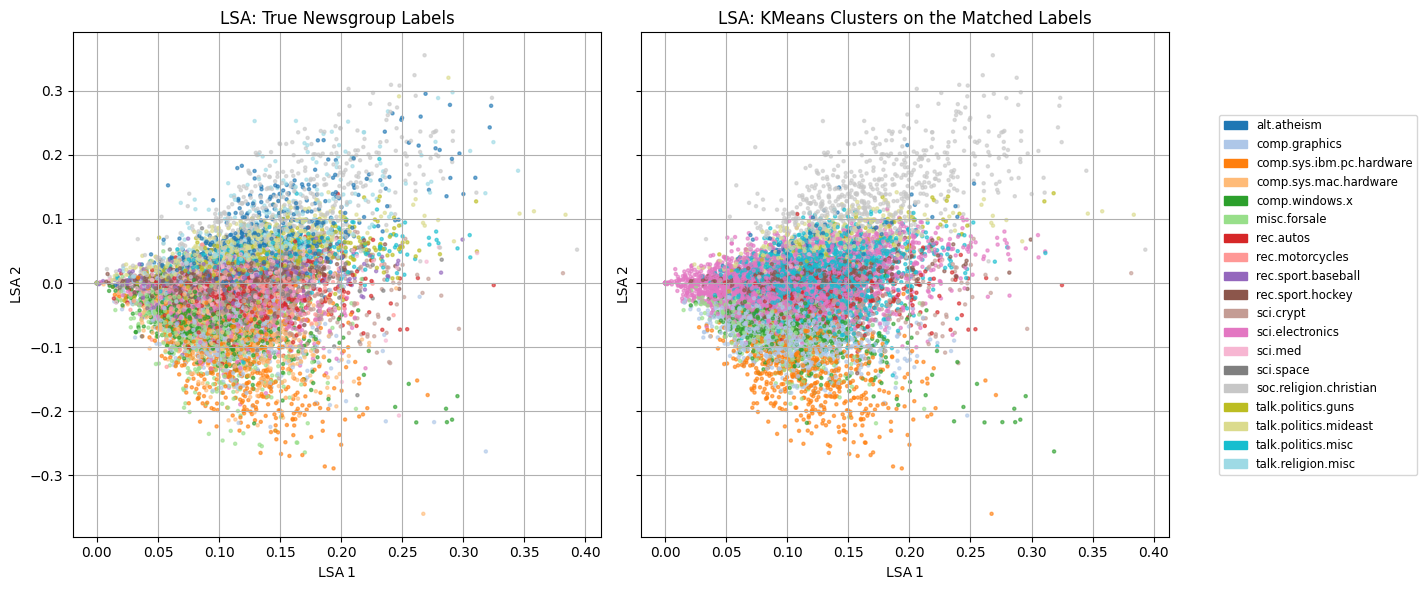

In [ ]:
# Creating a colormap for the 19 categorys
cmap = plt.get_cmap('tab20', n_categories)
category_colors = { labels[i]: cmap(i) for i in range(n_categories) }
true_colors = [ category_colors[ labels[true_i] ] for true_i in y ] # assign color labels

# Assign colors to the matched true category
cluster_to_matched = {
    i: labels[ closest_true_idx[i] ]
    for i in range(n_categories)
}
cluster_colors = [
    category_colors[ cluster_to_matched[c] ]
    for c in km.labels_
]

# side by side plot with LSA reduced axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)

ax1.scatter(X_reduced[:, 0], X_reduced[:, 1],c=true_colors, s=5, alpha=0.6) # true colors
ax1.set_title("LSA: True Newsgroup Labels")
ax1.set_xlabel("LSA 1"); ax1.set_ylabel("LSA 2")
ax1.grid(True)

ax2.scatter(X_reduced[:, 0], X_reduced[:, 1],c=cluster_colors, s=5, alpha=0.6) # cluster colors
ax2.set_title("LSA: KMeans Clusters on the Matched Labels")
ax2.set_xlabel("LSA 1"); ax2.set_ylabel("LSA 2")
ax2.grid(True)

# create the legend of categories and colors
Legend = [mpatches.Patch(color=category_colors[l], label=l)for l in labels]
fig.legend(
    Legend, labels,
    loc='center right',
    bbox_to_anchor=(1.02, 0.5),
    fontsize='small', ncol=1
)

plt.tight_layout(rect=[0,0,0.85,1])
plt.show()


# Plot Takeaways
1. High degree of overlap among documents.
2. general topics are captured on the edges, but lots of overlap in the clearly shown.

# Conclusion
1. Categories with tight vocabularies (forsale, hockey, space, certain hardware/graphics subtopics) we're clustered very well.
2. Categories without consistent terminology and noise struggled.
3. The data still had high degree of overlap despite LSA reduction.
4. Kmeans LSA performed the fastest and similar performance as PCA

## Future Work

1. Fine tuning Vectorization could perhaps improve results.

2. Exploration into N-grams to capture more semantic meaning and multi-word terms. For example: **Happy Valley** treated separately doesn't carry much meaning but a Bi-gram of [Happy Valley] would carry more meaning.

3. Apply word embeddings, essentially treat each word as a Vector using dynamic or static NLP models and then average the vectors to have a single resulting vector for each document, then apply Clustering. The advantage is the models group similar terms like Apple or Orange in similar vector coordinates and thus improve accuracy over simple TF-IDF. The resulting matrix will be ~500 dimensional denser Vectorized documents to cluster rather than the highly dimensional sparesely populated one.